In [1]:
DATE = "2021-09-14"
TASK = "pacbio-assembly"
DIR = mkpath("$(homedir())/$(DATE)-$(TASK)")

"/home/jovyan/2021-09-14-pacbio-assembly"

In [2]:
import Pkg
pkgs = [
    "BioAlignments",
    "BioSequences",
    "Clustering",
#     "CodecZlib",
#     "Colors",
#     "Combinatorics",
    "DataFrames",
    "DataStructures",
    "Dates",
#     "DelimitedFiles",
    "Distances",
#     "Distributions",
#     "EzXML",
    "FASTX",
#     "GFF3",
    "GLM",
    "GraphPlot",
#     "HTTP",
#     "Impute",
#     "JSON",
    "LightGraphs",
#     "LSHFunctions",
#     "Measures",
    "MetaGraphs",
    "https://github.com/cjprybol/Mycelia.git",
#     "NumericIO",
#     "PlotlyJS",
#     "Plots",
    "Primes",
#     "Printf",
    "ProgressMeter",
    "Random",
    "Revise",
    "SparseArrays",
    "Statistics",
    "StatsBase",
    "StatsPlots",
#     "StringDistances",
    "uCSV",
#     "XLSX",
]

unregistered_packages = filter(pkg -> occursin(r"(^https|git$)", pkg), pkgs)
registered_packages = setdiff(pkgs, unregistered_packages)

for pkg in registered_packages
    try
        eval(Meta.parse("import $(pkg)"))
    catch
        Pkg.add(pkg)
        Pkg.build(pkg)
        eval(Meta.parse("import $(pkg)"))
    end
end

for pkg_url in unregistered_packages
    pkg_name = replace(basename(pkg_url), ".git" => "")
    try
        eval(Meta.parse("import $(pkg_name)"))
    catch
        Pkg.develop(url=pkg_url)
        Pkg.build(pkg_name)
        eval(Meta.parse("import $(pkg_name)"))
    end
end

In [3]:
function kmer_index_and_orientation_to_kmer(graph, kmer_index, orientation)
    kmer = graph.vprops[kmer_index][:kmer]
    if !orientation
        kmer = BioSequences.reverse_complement(kmer)
    end
    return kmer
end

kmer_index_and_orientation_to_kmer (generic function with 1 method)

In [4]:
function determine_edge_probabilities(graph)
    nv = LightGraphs.nv(graph)
    edge_probabilities = SparseArrays.spzeros(nv, nv)
    for v in 1:nv
        neighbors = LightGraphs.neighbors(graph, v)
        @assert issorted(neighbors)
        likelihoods = zeros(length(neighbors))
        for (i, neighbor) in enumerate(neighbors)
            if v <= neighbor
                edge = LightGraphs.Edge(v, neighbor)
            else
                edge = LightGraphs.Edge(neighbor, v)
            end
            @assert LightGraphs.has_edge(graph, edge)
            likelihoods[i] = graph.eprops[edge][:count]     
        end
        likelihoods = likelihoods ./ sum(likelihoods)
#         @show likelihoods
#         @show neighbors
        for (neighbor, likelihood) in zip(neighbors, likelihoods)
            edge_probabilities[v, neighbor] = likelihood
        end
    end
    
    for source in 1:size(edge_probabilities, 1)
        destinations = findall(edge_probabilities[source, :] .> 0)
        destination_counts = [graph.vprops[dest][:count] for dest in destinations]
        destination_likelihoods = destination_counts ./ sum(destination_counts)
        for (dest, likelihood) in zip(destinations, destination_likelihoods)
            edge_probabilities[source, dest] *= likelihood
        end
        edge_probabilities[source, :] ./= sum(edge_probabilities[source, :])
        @assert abs(1-sum(edge_probabilities[source, :])) <= eps(Float64)
    end
    
    return edge_probabilities
end

determine_edge_probabilities (generic function with 1 method)

In [5]:
function orient_path(graph, kmers, path, opening_orientation, opening_kmer, closing_orientation)
    vertices = path
    path_orientations = [opening_orientation]
    path_kmers = [opening_kmer]
    @show opening_orientation
    for (i, vertex) in enumerate(vertices[2:end])
        @show i, vertex, last(path_orientations)
        viable_neighbors = typeof(opening_kmer)[]
        viable_neighbor = nothing
        viable_orientations = Bool[]
        viable_orientation = nothing
        for neighbor in BioSequences.neighbors(last(path_kmers))
            @show "considering going from $(last(path_kmers)) to $(neighbor)"
#             @show "considering going from $(last(path_kmers)) to $(neighbor)"
            canonical_neighbor = BioSequences.canonical(neighbor)
            canonical_neighbor_index_range = searchsorted(kmers, canonical_neighbor)
#             @show canonical_neighbor_index_range
            if length(canonical_neighbor_index_range) == 1
                @show canonical_neighbor_index = first(canonical_neighbor_index_range)
                if canonical_neighbor_index == vertex
                    @show "hit, selecting $neighbor"
                    viable_neighbor = neighbor
                    viable_orientation = neighbor == canonical_neighbor
                end
            end
        end
        if (viable_neighbor != nothing) && (viable_orientation != nothing)
            push!(path_kmers, viable_neighbor)
            push!(path_orientations, viable_orientation)
        else
            return nothing
            # not a viable path, need to look towards the next miss
        end
    end
    return vertices, path_orientations, path_kmers
end

orient_path (generic function with 1 method)

In [6]:
function take_a_walk(graph, edge_likelihoods, kmers, kmer, walk_length)
    walk = [kmer]
    current_kmer_indices = searchsorted(kmers, BioSequences.canonical(last(walk)))
    @assert length(current_kmer_indices) == 1
    current_kmer_index = first(current_kmer_indices)
    while length(walk) < walk_length
        viable_neighbors = Tuple{Int, Bool}[]
        for neighbor in BioSequences.neighbors(kmer)
            canonical_neighbor = BioSequences.canonical(neighbor)
            neighbor_is_canonical = neighbor == canonical_neighbor
            neighbor_vertex_range = searchsorted(kmers, canonical_neighbor)
            if !isempty(neighbor_vertex_range)
                neighbor_vertex = first(neighbor_vertex_range)
                if LightGraphs.has_edge(graph, current_kmer_index, neighbor_vertex)
                    push!(viable_neighbors, (neighbor_vertex, neighbor_is_canonical))
                end
            end
        end
        if isempty(viable_neighbors)
            return walk
        elseif length(viable_neighbors) == 1
            chosen_neighbor = first(viable_neighbors)
        else
            viable_neighbor_indices = first.(viable_neighbors)
            step_likelihoods = StatsBase.weights(edge_likelihoods[current_kmer_index, viable_neighbor_indices])
            chosen_neighbor = StatsBase.sample(viable_neighbors, step_likelihoods)
        end
        kmer = kmer_index_and_orientation_to_kmer(graph, chosen_neighbor...)
        push!(walk, kmer)
        current_kmer_indices = searchsorted(kmers, BioSequences.canonical(last(walk)))
        @assert length(current_kmer_indices) == 1
        current_kmer_index = first(current_kmer_indices)
    end
    return walk
end

take_a_walk (generic function with 1 method)

In [7]:
"""
    sort_fastq(input_fastq, output_fastq)

This turns a 4-line FASTQ entry into a single tab separated line,
adds a column with the length of each read, passes it to Unix sort,
removes the length column, and converts it back into a FASTQ file.

sorts longest to shortest!!

http://thegenomefactory.blogspot.com/2012/11/sorting-fastq-files-by-sequence-length.html
"""
function sort_fastq(input_fastq, output_fastq="")
    
    if endswith(input_fastq, ".gz")
        p = pipeline(
                `gzip -dc $input_fastq`,
                `paste - - - -`,
                `perl -ne '@x=split m/\t/; unshift @x, length($x[1]); print join "\t",@x;'`,
                `sort -nr`,
                `cut -f2-`,
                `tr "\t" "\n"`,
                `gzip`
                )
    else
        p = pipeline(
                `cat $input_fastq`,
                `paste - - - -`,
                `perl -ne '@x=split m/\t/; unshift @x, length($x[1]); print join "\t",@x;'`,
                `sort -nr`,
                `cut -f2-`,
                `tr "\t" "\n"`
                )
    end
    run(pipeline(p, output_fastq))
    return output_fastq
end

sort_fastq

In [8]:
function count_reads(fastq_file)
    n_reads = 0
    for record in Mycelia.open_fastx(fastq_file)
        n_reads += 1
    end
    return n_reads
end

count_reads (generic function with 1 method)

In [9]:
function max_canonical_kmers(kmer_type)
    k_size = last(kmer_type.parameters)
    # we only consider canonical kmers so cut in 1/2
    max_canonical_kmers = Int(4^k_size / 2)
    return max_canonical_kmers
end

max_canonical_kmers (generic function with 1 method)

In [10]:
function assess_kmer_saturation(fastq_file, kmer_type; max_reads=Inf, power=10)
    canonical_kmers = Set{kmer_type}()
    repeat_kmers = Set{kmer_type}()
    
    if max_reads == Inf
        @info "determining # of reads in file(s)"
        max_reads = count_reads(fastq_file)
    end
    
    @info "total reads being considered = $(max_reads)"
    
    max_kmers = max_canonical_kmers(kmer_type)

    @info "maximim kmers = $(max_kmers)"
    
    sampling_points = Int[0]
    i = 0
    while power^i <= max_reads
        push!(sampling_points, power^i)
        i += 1
    end
    
    repeat_kmer_counts = zeros(Int, length(sampling_points))
    p = ProgressMeter.Progress(max_reads, 1)
    
    read_number = 0
    for record in Mycelia.open_fastx(fastq_file)
        hit_max_reads = (read_number > sampling_points[end])
        hit_saturation = 
        hit_max_reads && break
        read_number += 1
        ProgressMeter.next!(p)
        for kmer in BioSequences.each(kmer_type, FASTX.sequence(record))
            canonical_kmer = kmer.fw < kmer.bw ? kmer.fw : kmer.bw
            if canonical_kmer in canonical_kmers
                push!(repeat_kmers, canonical_kmer)
            else
                push!(canonical_kmers, canonical_kmer)
            end
        end
        n_kmers = length(repeat_kmers)
        if n_kmers == max_kmers
            sampling_points = vcat(filter(s -> s < read_number, sampling_points), [read_number])
            repeat_kmer_counts = vcat(repeat_kmer_counts[1:length(sampling_points)-1], n_kmers)
            break
        elseif rem(log(power, read_number), 1) == 0.0
            i = findfirst(sampling_points .== read_number)
            repeat_kmer_counts[i] = n_kmers
            percent_saturation = round(n_kmers/max_kmers, sigdigits=5) * 100
            @show read_number, percent_saturation
        end
    end
    return (;sampling_points, repeat_kmer_counts)
end

assess_kmer_saturation (generic function with 1 method)

In [11]:
# read in reads from pacbio run

In [12]:
# fastq_directory = "$(homedir())/pacbio-test-data"
# fastq_file = first(readdir(fastq_directory, join=true))
fastq_file = "$(homedir())/pacbio-test-data/b002225.subreads.fastq.gz"

"/home/jovyan/pacbio-test-data/b002225.subreads.fastq.gz"

In [13]:
# sort fastq file from shortest to longest reads

In [14]:
sorted_fastq_file = replace(fastq_file, r"\.fastq\.gz$" => ".sorted.fastq.gz")
# @time sort_fastq(fastq_file, sorted_fastq_file)
# 62 minutes!

"/home/jovyan/pacbio-test-data/b002225.subreads.sorted.fastq.gz"

In [21]:
max_reads = count_reads(fastq_file)

1970799

In [22]:
n_reads = min(10_000, Int(ceil(max_reads/100)))

10000

In [16]:
ks = Primes.primes(3, 31)

10-element Vector{Int64}:
  3
  5
  7
 11
 13
 17
 19
 23
 29
 31

In [17]:
k = ks[1]
kmer_type = BioSequences.DNAMer{k}

BioSequences.Mer{BioSequences.DNAAlphabet{2}, 3}

┌ Info: total reads being considered = 10000
└ @ Main In[10]:10
┌ Info: maximim kmers = 32
└ @ Main In[10]:14


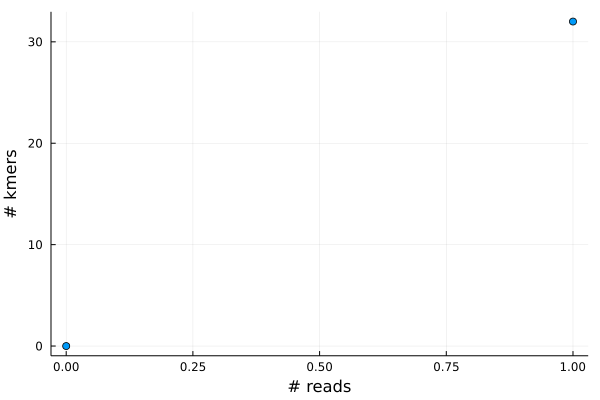

In [20]:
sampling_points, repeat_kmer_counts = assess_kmer_saturation(sorted_fastq_file, kmer_type, max_reads=n_reads, power=2)
StatsPlots.scatter(sampling_points, repeat_kmer_counts, legend=false, ylabel="# kmers", xlabel="# reads")

In [23]:
x = 1 ./sampling_points[2:end]
y = 1 ./repeat_kmer_counts[2:end]
# StatsPlots.scatter(x, y, legend=false)
model = GLM.lm(GLM.@formula(Y ~ X), DataFrames.DataFrame(X = x, Y = y))
# y-intercept = 1/vmax
b = GLM.coef(model)[1]
vmax = 1/b
@show vmax
sparsity = vmax / max_canonical_kmers(kmer_type)
@show sparsity
m = GLM.coef(model)[2]
X_intercept = (0 - b) / m
# x-intercept = -1/KM
k_midpoint = -1/X_intercept
if (sparsity) < 1
    @show "acheived sparsity"
    @show k_midpoint
end

In [24]:
k = ks[2]
kmer_type = BioSequences.DNAMer{k}

BioSequences.DNAMer{5} (alias for BioSequences.Mer{BioSequences.DNAAlphabet{2}, 5})

┌ Info: total reads being considered = 10000
└ @ Main In[10]:10
┌ Info: maximim kmers = 512
└ @ Main In[10]:14


(read_number, percent_saturation) = (1, 99.80499999999999)


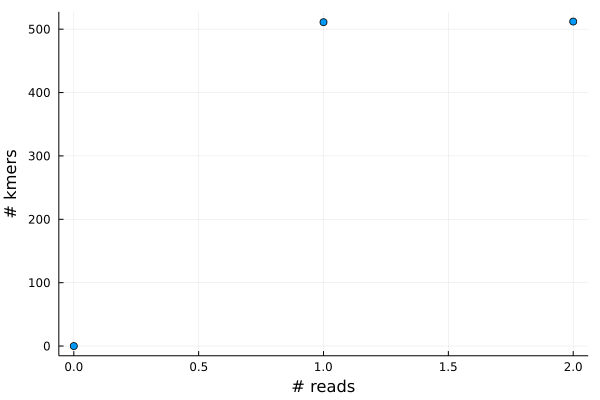

In [25]:
sampling_points, repeat_kmer_counts = assess_kmer_saturation(sorted_fastq_file, kmer_type, max_reads=n_reads, power=2)
StatsPlots.scatter(sampling_points, repeat_kmer_counts, legend=false, ylabel="# kmers", xlabel="# reads")

In [26]:
x = 1 ./sampling_points[2:end]
y = 1 ./repeat_kmer_counts[2:end]
# StatsPlots.scatter(x, y, legend=false)
model = GLM.lm(GLM.@formula(Y ~ X), DataFrames.DataFrame(X = x, Y = y))
# y-intercept = 1/vmax
b = GLM.coef(model)[1]
vmax = 1/b
@show vmax
sparsity = vmax / max_canonical_kmers(kmer_type)
@show sparsity
m = GLM.coef(model)[2]
X_intercept = (0 - b) / m
# x-intercept = -1/KM
k_midpoint = -1/X_intercept
if (sparsity) < 1
    @show "acheived sparsity"
    @show k_midpoint
end

In [27]:
k = ks[3]
kmer_type = BioSequences.DNAMer{k}

BioSequences.DNAMer{7} (alias for BioSequences.Mer{BioSequences.DNAAlphabet{2}, 7})

┌ Info: total reads being considered = 10000
└ @ Main In[10]:10
┌ Info: maximim kmers = 8192
└ @ Main In[10]:14


(read_number, percent_saturation) = (1, 41.772)
(read_number, percent_saturation) = (2, 91.187)
(read_number, percent_saturation) = (4, 98.694)
(read_number, percent_saturation) = (8, 99.976)


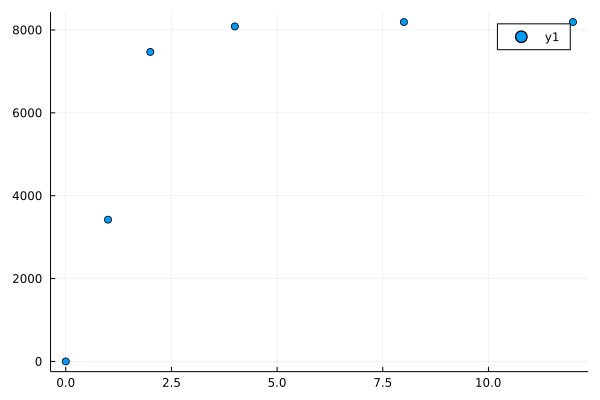

In [28]:
sampling_points, repeat_kmer_counts = assess_kmer_saturation(sorted_fastq_file, kmer_type, max_reads=n_reads, power=2)
StatsPlots.scatter(sampling_points, repeat_kmer_counts)

In [29]:
x = 1 ./sampling_points[2:end]
y = 1 ./repeat_kmer_counts[2:end]
# StatsPlots.scatter(x, y, legend=false)
model = GLM.lm(GLM.@formula(Y ~ X), DataFrames.DataFrame(X = x, Y = y))
# y-intercept = 1/vmax
b = GLM.coef(model)[1]
vmax = 1/b
@show vmax
sparsity = vmax / max_canonical_kmers(kmer_type)
@show sparsity
m = GLM.coef(model)[2]
X_intercept = (0 - b) / m
# x-intercept = -1/KM
k_midpoint = -1/X_intercept
if (sparsity) < 1
    @show "acheived sparsity"
    @show k_midpoint
end

In [30]:
k = ks[4]
kmer_type = BioSequences.DNAMer{k}

BioSequences.DNAMer{11} (alias for BioSequences.Mer{BioSequences.DNAAlphabet{2}, 11})

In [ ]:
sampling_points, repeat_kmer_counts = assess_kmer_saturation(sorted_fastq_file, kmer_type, max_reads=n_reads, power=2)
StatsPlots.scatter(sampling_points, repeat_kmer_counts)

┌ Info: total reads being considered = 10000
└ @ Main In[10]:10
┌ Info: maximim kmers = 2097152
└ @ Main In[10]:14


(read_number, percent_saturation) = (1, 1.023)
(read_number, percent_saturation) = (2, 1.8458999999999999)
(read_number, percent_saturation) = (4, 3.2815999999999996)
(read_number, percent_saturation) = (8, 5.0761)


Progress:   0%|                                         |  ETA: 0:13:51

(read_number, percent_saturation) = (16, 10.56)
(read_number, percent_saturation) = (32, 18.3)
(read_number, percent_saturation) = (64, 33.219)


Progress:   1%|▌                                        |  ETA: 0:12:59

(read_number, percent_saturation) = (128, 55.60699999999999)


Progress:   2%|█                                        |  ETA: 0:11:24

(read_number, percent_saturation) = (256, 80.61399999999999)


Progress:   5%|██▏                                      |  ETA: 0:10:03

(read_number, percent_saturation) = (512, 94.119)


Progress:  10%|████▎                                    |  ETA: 0:08:19

(read_number, percent_saturation) = (1024, 99.22800000000001)


Progress:  11%|████▍                                    |  ETA: 0:08:10

In [ ]:
x = 1 ./sampling_points[2:end]
y = 1 ./repeat_kmer_counts[2:end]
# StatsPlots.scatter(x, y, legend=false)
model = GLM.lm(GLM.@formula(Y ~ X), DataFrames.DataFrame(X = x, Y = y))
# y-intercept = 1/vmax
b = GLM.coef(model)[1]
vmax = 1/b
@show vmax
sparsity = vmax / max_canonical_kmers(kmer_type)
@show sparsity
m = GLM.coef(model)[2]
X_intercept = (0 - b) / m
# x-intercept = -1/KM
k_midpoint = -1/X_intercept
if (sparsity) < 1
    @show "acheived sparsity"
    @show k_midpoint
end

In [ ]:
k = ks[5]
kmer_type = BioSequences.DNAMer{k}

In [ ]:
sampling_points, repeat_kmer_counts = assess_kmer_saturation(sorted_fastq_file, kmer_type, max_reads=n_reads, power=2)
StatsPlots.scatter(sampling_points, repeat_kmer_counts)

In [ ]:
# can I use lineweaver burk plot to calculate vmax?
# https://youtu.be/koecLoRB2UE

In [ ]:
x = 1 ./sampling_points[2:end]
y = 1 ./repeat_kmer_counts[2:end]
# StatsPlots.scatter(x, y, legend=false)
model = GLM.lm(GLM.@formula(Y ~ X), DataFrames.DataFrame(X = x, Y = y))
# y-intercept = 1/vmax
b = GLM.coef(model)[1]
vmax = 1/b
sparsity = vmax / max_canonical_kmers(kmer_type)
m = GLM.coef(model)[2]
X_intercept = (0 - b) / m
# x-intercept = -1/KM
k_midpoint = -1/X_intercept
if (sparsity) < 1
    @show "acheived sparsity"
    @show k_midpoint
end

In [ ]:
n_reads_to_sample = Int(ceil(max(n_reads, k_midpoint)))

In [ ]:
# fit linear regression against this

In [ ]:
# solve for vmax

In [ ]:
# if vmax < maximum possible kmers, we've hit saturation

In [ ]:
# figure out how many reads we need to get to km

In [ ]:
# downsample to km

In [ ]:
# plot kmer spectra frequency

In [ ]:
kmer_counts = sort!(Mycelia.count_canonical_kmers(BioSequences.BigDNAMer{k}, genome))

In [ ]:
K = length(keys(kmer_counts))

In [ ]:
# create an undirected kmer graph from the sequence

In [ ]:
graph = MetaGraphs.MetaGraph(K)

In [ ]:
for (i, (kmer, count)) in enumerate(kmer_counts)
    @show i, kmer, count
    @show MetaGraphs.set_prop!(graph, i, :kmer, kmer)
    @show MetaGraphs.set_prop!(graph, i, :count, count)
end

In [ ]:
graph.vprops

In [ ]:
kmers = collect(keys(kmer_counts))

In [ ]:
for i in 1:length(genome)-k
    edge_range = i:i+k
    edge = genome[edge_range]
    src = BioSequences.BigDNAMer{k}(edge[1:end-1])
    dst = BioSequences.BigDNAMer{k}(edge[2:end])
    canonical_src = BioSequences.canonical(src)
    canonical_dst = BioSequences.canonical(dst)
    src_index = Mycelia.get_kmer_index(kmers, canonical_src)
    dst_index = Mycelia.get_kmer_index(kmers, canonical_dst)
    @show edge
    @show src_index, src == canonical_src, dst_index, dst == canonical_dst
    graph_edge = LightGraphs.Edge(src_index, dst_index)
    if LightGraphs.has_edge(graph, graph_edge)
        current_count = graph.eprops[graph_edge][:count]
        MetaGraphs.set_prop!(graph, graph_edge, :count, current_count+1)
    else
        LightGraphs.add_edge!(graph, graph_edge)
        MetaGraphs.set_prop!(graph, graph_edge, :count, 1)
    end
end

In [ ]:
graph

In [ ]:
graph.eprops

In [ ]:
nodesize = [graph.vprops[v][:count] for v in 1:LightGraphs.nv(graph)]
nodelabel = [graph.vprops[v][:kmer] for v in 1:LightGraphs.nv(graph)]
# GraphPlot.gplot(graph, nodesize=nodesize, nodelabel=nodelabel)
GraphPlot.gplot(graph, nodesize=nodesize)

In [ ]:
edge_likelihoods = determine_edge_probabilities(graph)

In [ ]:
# take yen_k shortest paths

In [ ]:
genome_kmers = collect(BioSequences.each(BioSequences.BigDNAMer{k}, genome))

In [ ]:
# make a SNP edit to the genome

In [ ]:
# seed = 0
# seed = 1
# seed = 2
# seed = 3
# seed = 4
# seed = 5
# seed = 6
# seed = 7
# seed = 8
seed = 9

In [ ]:
@show seed
Random.seed!(seed)
observation = Mycelia.observe(genome, error_rate = 0.1)

In [ ]:
alignment = BioAlignments.pairalign(BioAlignments.LevenshteinDistance(), observation, genome)

In [ ]:
reverse_alignment = BioAlignments.pairalign(BioAlignments.LevenshteinDistance(), BioSequences.reverse_complement(observation), genome)

In [ ]:
if reverse_alignment.value < alignment.value
    observation = BioSequences.reverse_complement(observation)
    alignment = reverse_alignment
    @show "flipping"
end

In [ ]:
# convert genome into stranded path

In [ ]:
# function sequence_to_
observation_as_oriented_kmers = []
observation_kmers = collect(BioSequences.each(BioSequences.BigDNAMer{k}, observation))

In [ ]:
genome_kmers

In [ ]:
is_canonical = falses(length(observation_kmers))
kmer_index = zeros(Int, length(observation_kmers))
for (i, kmer) in enumerate(observation_kmers)
#     is_canonical[i] = kmer.fw <= kmer.bw
    canonical_kmer = BioSequences.canonical(kmer.fw)
    is_canonical[i] = kmer.fw == canonical_kmer
    kmer_index_range = searchsorted(kmers, canonical_kmer)
    if length(kmer_index_range) > 1
        @error "bad"
    elseif isempty(kmer_index_range)
        # do nothing, index is 0 to indicate not found
    else
        kmer_index[i] = first(kmer_index_range)
    end
end

In [ ]:
is_canonical

In [ ]:
kmer_index

In [ ]:
proposed_path = BioSequences.BigDNAMer{k}[]
opening_missing_kmer_path_index = findfirst(x -> x == 0, kmer_index)

# read is solid!
if opening_missing_kmer_path_index == nothing
#     proposed_seq = observation
    proposed_path = [kmer.fw for kmer in observation_kmers]
    @show "perfect read"
elseif all(index -> index == 0, kmer_index)
    @show "read is trash"
    # generate a new read from the assembly to replace this one

    observation_path_length = length(observation_kmers)
    proposed_path = nothing
    proposed_path_size_discrepancy = Inf
    starting_kmer_indices = StatsBase.sample(1:LightGraphs.nv(graph), min(10, LightGraphs.nv(graph)), replace=false)
    for starting_kmer_index in starting_kmer_indices
        starting_kmer_index = rand(1:LightGraphs.nv(graph))
        @show starting_kmer_index
        starting_kmer = graph.vprops[starting_kmer_index][:kmer]
        if rand(Bool)
            starting_kmer = BioSequences.reverse_complement(starting_kmer)
        end
        candidate_path = take_a_walk(graph, edge_likelihoods, kmers, starting_kmer, observation_path_length)
        discrepancy = abs(length(candidate_path) - observation_path_length)
        @show discrepancy
        if discrepancy < proposed_path_size_discrepancy
            proposed_path = candidate_path
            proposed_path_size_discrepancy = discrepancy
            if proposed_path_size_discrepancy == 0
                break
            end
        end
    end
else
    if opening_missing_kmer_path_index == 1
        opening_solid_kmer = nothing
    #     closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), opening_missing_kmer_path_index+1)
    elseif opening_missing_kmer_path_index != nothing
        opening_solid_kmer_path_index = opening_missing_kmer_path_index - 1
        opening_solid_kmer = observation_kmers[opening_solid_kmer_path_index].fw
    end

    if opening_missing_kmer_path_index == nothing
        closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), 1)
    else
        closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), opening_missing_kmer_path_index+1)
    end
    if closing_solid_kmer_path_index == nothing
        @show "end is open"
        closing_solid_kmer = nothing
    else
        closing_solid_kmer = observation_kmers[closing_solid_kmer_path_index].fw
    end


    extensions = 0
    while (opening_missing_kmer_path_index != nothing) && (extensions < 5)
        extensions += 1
        @show extensions

        if (opening_solid_kmer == nothing) && (closing_solid_kmer != nothing)
            @show "missing opening"
            @show closing_solid_kmer
            inverted_closing_solid_kmer = BioSequences.reverse_complement(closing_solid_kmer)
            @show inverted_closing_solid_kmer
            walk_length = closing_solid_kmer_path_index
            chosen_walk = take_a_walk(graph, edge_likelihoods, kmers, inverted_closing_solid_kmer, walk_length)
            chosen_walk = reverse(BioSequences.reverse_complement.(chosen_walk))
            @show chosen_walk
            @show closing_solid_kmer_path_index
            @assert observation_kmers[closing_solid_kmer_path_index].fw == last(chosen_walk)
            proposed_path = chosen_walk
            opening_missing_kmer_path_index = findnext(map(x -> x == 0, kmer_index), closing_solid_kmer_path_index+1)

            if opening_missing_kmer_path_index == 1
                opening_solid_kmer = nothing
            elseif opening_missing_kmer_path_index != nothing
                need_to_add = getproperty.(observation_kmers[closing_solid_kmer_path_index+1:opening_missing_kmer_path_index-1], :fw)
                append!(proposed_path, need_to_add)
                opening_solid_kmer_path_index = opening_missing_kmer_path_index - 1
                opening_solid_kmer = observation_kmers[opening_solid_kmer_path_index].fw
                closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), opening_missing_kmer_path_index+1)
                if closing_solid_kmer_path_index == nothing
                    closing_solid_kmer = nothing
                else
                    closing_solid_kmer = observation_kmers[closing_solid_kmer_path_index].fw
                end
            end
        end

        if (opening_solid_kmer != nothing) && (closing_solid_kmer == nothing)
            @show "missing closing"
            walk_length = length(observation_kmers) - opening_solid_kmer_path_index+1
            chosen_walk = take_a_walk(graph, edge_likelihoods, kmers, opening_solid_kmer, walk_length)
            @show chosen_walk
            @assert observation_kmers[opening_solid_kmer_path_index].fw == first(chosen_walk)
            if isempty(proposed_path)
                proposed_path = getproperty.(observation_kmers[1:opening_solid_kmer_path_index], :fw)
            end
            append!(proposed_path, chosen_walk[2:end])
            opening_missing_kmer_path_index = nothing
        end

        while (opening_solid_kmer != nothing) && (closing_solid_kmer != nothing)
            @show "bubble!"
            opening_solid_kmer_index = kmer_index[opening_solid_kmer_path_index]
            closing_solid_kmer_index = kmer_index[closing_solid_kmer_path_index]

            @show opening_solid_kmer, opening_solid_kmer_path_index
            @show closing_solid_kmer, closing_solid_kmer_path_index
            @show length(proposed_path)
            
            #####################################################################################
            # DETERMINE PATH LENGTH
            #####################################################################################
            # by default, we're assuming that we want to walk the same distance as our bubble + 1
            bubble_path_length = closing_solid_kmer_path_index - opening_solid_kmer_path_index + 1

            if opening_solid_kmer_index != closing_solid_kmer_index
                path = LightGraphs.a_star(graph, opening_solid_kmer_index, closing_solid_kmer_index)
                normalized_path = Int[path[1].src, [edge.dst for edge in path]...]
                shortest_paths = [normalized_path]
            else
                neighbors = LightGraphs.neighbors(graph, opening_solid_kmer_index)
                shortest_paths = Vector{Vector{Int}}()
                for neighbor in neighbors
                    path = LightGraphs.a_star(graph, neighbor, closing_solid_kmer_index)
                    normalized_path = Int[path[1].src, [edge.dst for edge in path]...]
                    push!(shortest_paths, normalized_path)
                end
            end
            # but if our bubble is a deletion, then walking that length may not get us across to the other side
            # so we also determine the longest, shortest path
            longest_shortest_walk_length = maximum(length.(shortest_paths))


            longest_walk_length = max(bubble_path_length, longest_shortest_walk_length)
            walk_length = Int(ceil(longest_walk_length * 1.1))

            walks = Vector{Int}[]
            for i in 1:3
                println("round $i")
                walks = [take_a_walk(graph, edge_likelihoods, kmers, opening_solid_kmer, walk_length)]
                while allunique(walks)
                    push!(walks, take_a_walk(graph, edge_likelihoods, kmers, opening_solid_kmer, walk_length))
                end

                walks = filter(path -> closing_solid_kmer in path, walks)

                if isempty(walks)
                    walk_length = Int(ceil(walk_length * 1.1))
                else
                    # done!
                    break
                end
            end

            if !isempty(walks)
                candidate_paths = sort(collect(StatsBase.countmap(walks)), by=x->x[2], rev=true)
                selected_path = first(first(candidate_paths))
                selected_path_closing_solid_kmer_intersects = findall(kmer -> kmer == closing_solid_kmer, selected_path)
                if length(selected_path_closing_solid_kmer_intersects) > 1
                    @show "here"
                    selected_path_closing_solid_kmer_intersect = 0
                    d = Inf
                    for i in selected_path_closing_solid_kmer_intersects
                        candidate_distance = abs(i - walk_length)
                        if candidate_distance < d
                            d = candidate_distance
                            selected_path_closing_solid_kmer_intersect = i
                        end
                    end
                else
                    selected_path_closing_solid_kmer_intersect = first(selected_path_closing_solid_kmer_intersects)
                end
                selected_path = selected_path[1:selected_path_closing_solid_kmer_intersect]
                if isempty(proposed_path)
                    proposed_path = getproperty.(observation_kmers[1:opening_solid_kmer_path_index], :fw)
                end
                append!(proposed_path, selected_path[2:end])
                opening_missing_kmer_path_index = findnext(map(x -> x == 0, kmer_index), closing_solid_kmer_path_index+1)
                if opening_missing_kmer_path_index == nothing
                    #done
                    opening_solid_kmer = nothing
                elseif opening_missing_kmer_path_index == 1
                    # also done?
                    opening_solid_kmer = nothing
                elseif opening_missing_kmer_path_index != nothing
                    need_to_add = getproperty.(observation_kmers[closing_solid_kmer_path_index+1:opening_missing_kmer_path_index-1], :fw)
                    append!(proposed_path, need_to_add)
                    opening_solid_kmer_path_index = opening_missing_kmer_path_index - 1
                    opening_solid_kmer = observation_kmers[opening_solid_kmer_path_index].fw
                    closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), opening_missing_kmer_path_index+1)
                    if closing_solid_kmer_path_index == nothing
                        closing_solid_kmer = nothing
                    else
                        closing_solid_kmer = observation_kmers[closing_solid_kmer_path_index].fw
                    end
                end
            else
                @show "need to bump out"
                if opening_missing_kmer_path_index >= 2
                    opening_missing_kmer_path_index -= 1
                    opening_solid_kmer = nothing
                    # this should now break out to larger while loop
                end
                # push out closing node and try again
                closing_solid_kmer_path_index = findnext(map(x -> x != 0, kmer_index), closing_solid_kmer_path_index+1)

                if closing_solid_kmer_path_index == nothing
                    @show "end is open"
                    closing_solid_kmer = nothing
                else
                    closing_solid_kmer = observation_kmers[closing_solid_kmer_path_index].fw
                end
            end
        end
    end
    if closing_solid_kmer_path_index != nothing
        append!(proposed_path, getproperty.(observation_kmers[closing_solid_kmer_path_index+1:end], :fw))
    end
end

In [ ]:
proposed_path

In [ ]:
proposed_seq = BioSequences.LongDNASeq(first(proposed_path))
for kmer in proposed_path[2:end]
    push!(proposed_seq, last(kmer))
end
proposed_seq

In [ ]:
new_alignment = BioAlignments.pairalign(BioAlignments.LevenshteinDistance(), proposed_seq, genome)

In [ ]:
reverse_new_alignment = BioAlignments.pairalign(BioAlignments.LevenshteinDistance(), BioSequences.reverse_complement(proposed_seq), genome)

In [ ]:
if reverse_new_alignment.value < new_alignment.value
#     observation = BioSequences.reverse_complement!(observation)
    new_alignment = reverse_new_alignment
    @show "flipping"
end

In [ ]:
if new_alignment.value <= alignment.value
    @show "newer is equivalent or better"
    @show new_alignment.value, alignment.value
else
    @show "newer is worse, keep original"
    @show new_alignment.value, alignment.value
end